## Reto 1: Pruebas A/B

### 1. Objetivos:
    - Practicar evaluar los resultados de una Prueba A/B
 
---
    
### 2. Desarrollo:

### a) Evaluando una prueba A/B de flujo de ventas

El archivo 'ab_test-sales_pipeline-2' tiene datos muy similares a los que vimos en el último ejemplo. Estamos evaluando dos flujos de ventas distintos: A y B. Cada vez que alguien compró el producto gracias a uno de los dos flujos, se registró como un `1` en la columna `conversion` y un `0` en la columna `no conversion`.

Evalúa la prueba A/B para saber si los resultados obtenidos son estadísticamente significativos. El Reto consiste en los siguientes pasos:

1. Primero cuantifica cuál de los flujos de ventas fue más efectivo y en qué proporción.
2. Después aplica el test de permutación:
    1. Combina los resultados de ambos grupos en un mismo conjunto de datos
    2. Revuelve los datos
    3. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
    4. El resto de los datos conforman nuestro nuevo grupo B.
    5. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
    6. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.
3. Grafica tus resultados en un histograma y grafica una línea vertical que marque el resultado del experimento.
4. Cuantifica el Valor P y evalúa la significación estadística con un Alfa de 0.05 (5%).
5. Comenta tus hallazgos con tus compañeros y la experta.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv("https://github.com/beduExpert/B2-Analisis-de-Datos-con-Python-2020-Santander/raw/main/Datasets/ab_test-sales_pipeline-2.csv")
df.head(10)

,test,conversion,no conversion
0,A,0,1
1,B,0,1
2,A,0,1
3,A,0,1
4,B,0,1
5,B,0,1
6,A,1,0
7,B,0,1
8,B,0,1
9,B,0,1


In [46]:
counts = df.groupby("test")[["conversion", "no conversion"]].sum()
counts

,conversion,no conversion
test,,
A,4163,30576
B,4841,36747


In [47]:
counts["rate"] = counts["conversion"] / (counts["conversion"] + counts["no conversion"])
counts

,conversion,no conversion,rate
test,,,
A,4163,30576,0.119836
B,4841,36747,0.116404


In [14]:
diferencia_en_proporcion = 1 - (counts.loc['B']['rate'] / counts.loc['A']['rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100
print(f"A es {diferencia_en_porcentaje:.2f} mejor que B")

A es 2.86 mejor que B


In [18]:
all = df[["conversion", "no conversion"]]
all.head(5)

,conversion,no conversion
test,,
A,0,1
B,0,1
A,0,1
A,0,1
B,0,1


In [24]:
a_counts = all.loc["A"].shape[0]
a_counts

34739

In [37]:
conv_a = []; no_conv_a = []; conv_b = []; no_conv_b = [];

for _ in range(1000):
  new_as = all.sample(a_counts, replace=False)
  conv_a.append(new_as["conversion"].sum())
  no_conv_a.append(new_as["no conversion"].sum())

  new_bs = all.loc[~all.index.isin(new_as)]
  conv_b.append(new_bs["conversion"].sum())
  no_conv_b.append(new_bs["no conversion"].sum())

In [38]:
permutation_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

permutation_results.head(5)

,conv_a,no_conv_a,conv_b,no_conv_b
0,4150,30589,9004,67323
1,3994,30745,9004,67323
2,4207,30532,9004,67323
3,4084,30655,9004,67323
4,3995,30744,9004,67323
...,...,...,...,...
995,4069,30670,9004,67323
996,4134,30605,9004,67323
997,4061,30678,9004,67323
998,4167,30572,9004,67323


In [40]:
permutation_results['a_conv_rate'] = permutation_results['conv_a'] / (permutation_results['conv_a'] + permutation_results['no_conv_a'])
permutation_results['b_conv_rate'] = permutation_results['conv_b'] / (permutation_results['conv_b'] + permutation_results['no_conv_b'])
permutation_results.head(5)

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,4150,30589,9004,67323,0.119462,0.117966
1,3994,30745,9004,67323,0.114972,0.117966
2,4207,30532,9004,67323,0.121103,0.117966
3,4084,30655,9004,67323,0.117562,0.117966
4,3995,30744,9004,67323,0.115000,0.117966


In [42]:
permutation_results['diff'] = 1 - (permutation_results['b_conv_rate'] / permutation_results['a_conv_rate'])

permutation_results.head(5)

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,4150,30589,9004,67323,0.119462,0.117966,0.012524
1,3994,30745,9004,67323,0.114972,0.117966,-0.026045
2,4207,30532,9004,67323,0.121103,0.117966,0.025903
3,4084,30655,9004,67323,0.117562,0.117966,-0.003434
4,3995,30744,9004,67323,0.115000,0.117966,-0.025788


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


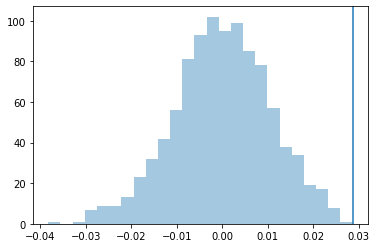

In [43]:
sns.distplot(x=permutation_results['diff'], kde=False, norm_hist=False)
plt.axvline(diferencia_en_proporcion);

In [44]:
print(f"p-value is: {(permutation_results['diff'] >= diferencia_en_proporcion).sum() / permutation_results.shape[0]}")

p-value is: 0.001
